# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Clear previously loaded data.
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [7]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.364007
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** There are 10 classes, each with a weight calculated using the same random number generation, so each weight will on average be 1/10 of the total value, and then also 1/10 once they are exponentiated, so the loss, calculated by taking that value and dividing by the total, and then taking the negative log, will be about -log(1/10), when they are averaged.

In [22]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.708597 analytic: -1.708597, relative error: 1.694494e-08
numerical: -0.176186 analytic: -0.176186, relative error: 2.439949e-07
numerical: 1.373252 analytic: 1.373252, relative error: 5.248213e-08
numerical: 1.889585 analytic: 1.889585, relative error: 8.429665e-10
numerical: 1.069360 analytic: 1.069360, relative error: 5.369128e-08
numerical: -0.213683 analytic: -0.213683, relative error: 9.924525e-08
numerical: 1.777028 analytic: 1.777028, relative error: 2.379077e-09
numerical: 2.304623 analytic: 2.304623, relative error: 7.616444e-09
numerical: -0.158570 analytic: -0.158570, relative error: 1.258064e-07
numerical: -0.667958 analytic: -0.667958, relative error: 6.581799e-08
numerical: 3.162542 analytic: 3.162542, relative error: 1.205901e-08
numerical: -4.204418 analytic: -4.204418, relative error: 1.427808e-08
numerical: 0.249176 analytic: 0.249176, relative error: 1.226591e-07
numerical: -3.813482 analytic: -3.813482, relative error: 5.875403e-11
numerical: 1.872882 

In [23]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.364007e+00 computed in 0.101080s
vectorized loss: 2.364007e+00 computed in 0.001915s
Loss difference: 0.000000
Gradient difference: 0.000000


In [21]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-6, 1e-7]
regularization_strengths = [1e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
import copy
num_LR_tests = 10
num_RS_tests = 5
iters_per_test = 1500
deltaLR = (learning_rates[1]-learning_rates[0])/(num_LR_tests-1)
deltaRS = (regularization_strengths[1]-regularization_strengths[0])/(num_RS_tests-1)
LR = learning_rates[0]
for i in range(num_LR_tests):
    RS = regularization_strengths[0]
    for j in range(num_RS_tests):
        testModel = Softmax()
        testModel.train(X_train, y_train, learning_rate=LR, reg=RS, num_iters=iters_per_test, verbose=True)
        y_train_pred = testModel.predict(X_train)
        y_val_pred = testModel.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = copy.deepcopy(testModel)
        results[(LR, RS)] = (np.mean(y_train == y_train_pred), val_acc)
        RS += deltaRS
    LR += deltaLR
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 308.253286
iteration 100 / 1500: loss 7.289980
iteration 200 / 1500: loss 2.056486
iteration 300 / 1500: loss 2.094063
iteration 400 / 1500: loss 1.992971
iteration 500 / 1500: loss 1.981794
iteration 600 / 1500: loss 1.990604
iteration 700 / 1500: loss 2.035297
iteration 800 / 1500: loss 1.986058
iteration 900 / 1500: loss 1.929933
iteration 1000 / 1500: loss 1.985861
iteration 1100 / 1500: loss 1.998403
iteration 1200 / 1500: loss 2.080851
iteration 1300 / 1500: loss 1.936568
iteration 1400 / 1500: loss 1.963213
iteration 0 / 1500: loss 621.488242
iteration 100 / 1500: loss 2.193836
iteration 200 / 1500: loss 2.130475
iteration 300 / 1500: loss 2.037328
iteration 400 / 1500: loss 2.048484
iteration 500 / 1500: loss 2.049028
iteration 600 / 1500: loss 2.084700
iteration 700 / 1500: loss 2.106748
iteration 800 / 1500: loss 2.036836
iteration 900 / 1500: loss 2.032249
iteration 1000 / 1500: loss 2.116106
iteration 1100 / 1500: loss 2.079506
iteration 1200 / 1500

iteration 200 / 1500: loss 3.117886
iteration 300 / 1500: loss 2.062376
iteration 400 / 1500: loss 2.110315
iteration 500 / 1500: loss 2.019971
iteration 600 / 1500: loss 2.043077
iteration 700 / 1500: loss 2.067924
iteration 800 / 1500: loss 2.021273
iteration 900 / 1500: loss 2.047672
iteration 1000 / 1500: loss 2.032109
iteration 1100 / 1500: loss 2.007173
iteration 1200 / 1500: loss 2.041800
iteration 1300 / 1500: loss 2.011077
iteration 1400 / 1500: loss 1.977272
iteration 0 / 1500: loss 621.823186
iteration 100 / 1500: loss 4.141653
iteration 200 / 1500: loss 2.067330
iteration 300 / 1500: loss 2.144439
iteration 400 / 1500: loss 2.090293
iteration 500 / 1500: loss 2.010879
iteration 600 / 1500: loss 2.068223
iteration 700 / 1500: loss 2.078971
iteration 800 / 1500: loss 2.078610
iteration 900 / 1500: loss 2.081736
iteration 1000 / 1500: loss 2.054624
iteration 1100 / 1500: loss 2.058085
iteration 1200 / 1500: loss 2.083574
iteration 1300 / 1500: loss 2.101854
iteration 1400 / 15

iteration 300 / 1500: loss 4.428216
iteration 400 / 1500: loss 2.458437
iteration 500 / 1500: loss 2.080498
iteration 600 / 1500: loss 2.036749
iteration 700 / 1500: loss 2.089785
iteration 800 / 1500: loss 2.039671
iteration 900 / 1500: loss 1.998769
iteration 1000 / 1500: loss 1.979647
iteration 1100 / 1500: loss 2.004799
iteration 1200 / 1500: loss 1.946422
iteration 1300 / 1500: loss 2.044959
iteration 1400 / 1500: loss 1.968976
iteration 0 / 1500: loss 623.780301
iteration 100 / 1500: loss 26.390907
iteration 200 / 1500: loss 3.077822
iteration 300 / 1500: loss 2.133723
iteration 400 / 1500: loss 1.971931
iteration 500 / 1500: loss 2.015127
iteration 600 / 1500: loss 2.030815
iteration 700 / 1500: loss 2.026811
iteration 800 / 1500: loss 2.089800
iteration 900 / 1500: loss 1.999234
iteration 1000 / 1500: loss 2.077436
iteration 1100 / 1500: loss 2.037243
iteration 1200 / 1500: loss 2.062674
iteration 1300 / 1500: loss 2.067823
iteration 1400 / 1500: loss 2.057068
iteration 0 / 150

iteration 400 / 1500: loss 63.662334
iteration 500 / 1500: loss 43.133064
iteration 600 / 1500: loss 29.506044
iteration 700 / 1500: loss 20.397024
iteration 800 / 1500: loss 14.286968
iteration 900 / 1500: loss 10.196848
iteration 1000 / 1500: loss 7.478467
iteration 1100 / 1500: loss 5.689147
iteration 1200 / 1500: loss 4.492230
iteration 1300 / 1500: loss 3.629129
iteration 1400 / 1500: loss 3.136530
iteration 0 / 1500: loss 619.210454
iteration 100 / 1500: loss 277.393547
iteration 200 / 1500: loss 125.279111
iteration 300 / 1500: loss 57.306408
iteration 400 / 1500: loss 26.770460
iteration 500 / 1500: loss 13.083089
iteration 600 / 1500: loss 7.077758
iteration 700 / 1500: loss 4.297009
iteration 800 / 1500: loss 3.040101
iteration 900 / 1500: loss 2.499053
iteration 1000 / 1500: loss 2.281009
iteration 1100 / 1500: loss 2.110512
iteration 1200 / 1500: loss 2.114955
iteration 1300 / 1500: loss 2.089493
iteration 1400 / 1500: loss 2.038304
iteration 0 / 1500: loss 924.421917
itera

In [24]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.355000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: 

*Your explanation*: 

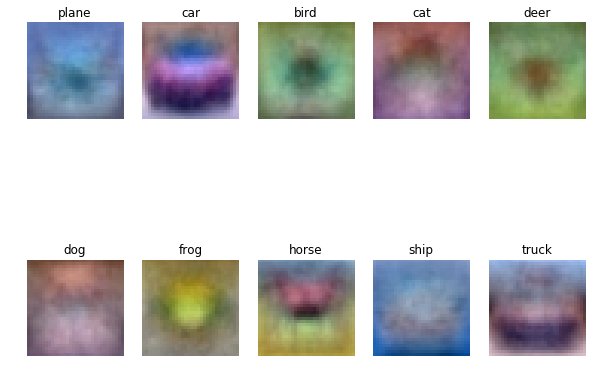

In [25]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])